In [8]:
import torch
import diffusers
import matplotlib.pyplot as plt
from common.dataset import MazeDataset

dataset = MazeDataset(maze_size=13)

noise_scheduler = diffusers.DDIMScheduler.from_config("runwayml/stable-diffusion-v1-5", subfolder="scheduler")

/home/ubuntu/miniconda3/lib/python3.11/site-packages/diffusers/configuration_utils.py:244: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddim.DDIMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
/home/ubuntu/miniconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [43]:
path_grid = dataset[0]["path_grid"].squeeze()

In [48]:
all_paths = [path_grid]

timesteps = [50, 100, 200, 250, 350]
for i, t in enumerate(timesteps):
    noise = torch.randn_like(path_grid)
    noisy_path = noise_scheduler.add_noise(path_grid, noise, timesteps=torch.tensor([t]).long())
    all_paths.append(noisy_path)

all_paths = torch.cat(all_paths, dim=-1)


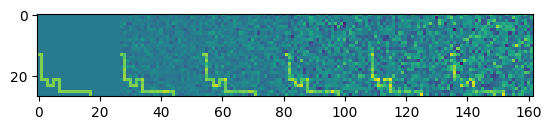

In [49]:
plt.imshow(all_paths)
# save
plt.savefig("/home/ubuntu/plt.png")

In [105]:
import torch.nn.functional as F
from common.dataset import visualize_maze
from PIL import Image

maze_size = 27

path = batch["path"]
maze = batch["maze_labeled"].long()
path = [torch.tensor(x) for x in path]
path = torch.stack(path, dim=0)
path = (path / maze_size) * 2 - 1 # [-1, 1]
noise = torch.randn_like(path) / 3

def vis(maze, coords):
    coords = coords / 2 + 0.5
    coords = coords * maze_size # scale relative back to actual maze dim
    coords = coords.round().long()
    coords = coords.clamp(0, maze_size - 1)

    maze = maze.squeeze()

    for j in range(coords.shape[0]):
        maze[coords[j, 1], coords[j, 0]] = 3
    
    solved_maze = visualize_maze(maze.float().cpu().numpy())
    return solved_maze

all_paths = []
timesteps = [0, 25, 100, 200, 300, 500]
for i, t in enumerate(timesteps):
    noisy_path = noise_scheduler.add_noise(path, noise, timesteps=torch.tensor([t]).long())
    solved_maze = vis(maze.clone(), noisy_path)
    all_paths.append(solved_maze)

canvas = Image.new('RGB', (solved_maze.width * len(all_paths), solved_maze.height))
for i, img in enumerate(all_paths):
    canvas.paste(img, (i * solved_maze.width, 0))

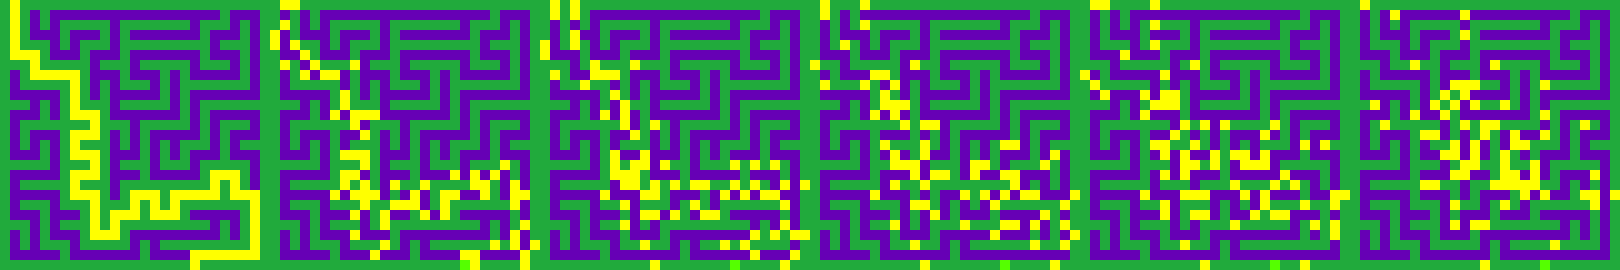

In [106]:
canvas

In [71]:
maze.shape

torch.Size([1, 27, 27])